# Association Rules

author: Karol Zioło

## Introduction

The aim of the association rules is  to determine and explain patterns in data. In other words these are if-then statements which help to present some probability of relationships between items. This method could be used in reserches concerning large datasets. It is very useful analysis for companies to predict choices of their customers. 

A good example, presenting utility of this method, is the analysis of customers grocery baskets. Based on their current choices it is possible to obtain the knowledge which products are associeted to each other so that companies would be able to predict that it is highly propable that some items would be chosen together. 
To obtain reliable results a couple of measures are used. The first one is Support which calculates the frequency that the itemset or rule occurs in the data. The second one is Confidence. It measures the percentage of transactions where the presence of one item results in the presence of the other item. The third measure is Lift. It is calculated by dividing the confidence by support of the second item. It indicates the strength of the association between items.

This study is focused on finding patterns of homicides in the USA. By using association rules it was possible to determine whether it is possible to create some profiles or pattrens of commited murders.

## Exploratory data analysis

For the purpose of the study the proper data set was collected. It was obtained from The Murder Accountability Project. It collected data of over 600k of homicides cases in the USA from 1976 to 2014. It was decided to focus on murders commited after 2010 because the aim of the study was to work with the most recent data as possible while maintaining a large number of observations. The other issue were variables which are not providing any valuable information. Below, the final variables were presented:
- Crime type: Murder or Manslslaughter, Manslaughter by Negligence;
- Crime solved: Crime Solved, Not Solved;
- Victim sex: Male, Female, Unknown;
- Victim age: Young, Middle, Old;
- Victim race: White, Black, Asian, Unknown and Native American;
- Prepatrator sex: Male, Female, Unknown;
- Victim age: Young, Middle, Old;
- Victim race: White, Black, Asian, Unknown and Native American;
- Relationship;
- Weapon. 

In [1]:
import pandas as pd
import numpy as np
from apyori import apriori
import matplotlib.pyplot as plt
import mlxtend
import seaborn as sns
import plotly.express as px
from pandas.plotting import parallel_coordinates

In [2]:
data = pd.read_csv("database.csv")
data = data[data["Year"]>2010]
data = data.drop(["Record ID", 'Agency Code', 'Agency Name', 'Agency Type', 'City',
       'State', 'Year', 'Month', 'Incident','Victim Ethnicity',
       'Perpetrator Ethnicity', 'Victim Count',
       'Perpetrator Count', 'Record Source'], axis=1)

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The next step was to downgrade the Victim Age and Perpetrator Age to ordinal variables. But before, it was necessary to examine more carefully the Perpetrator Age because it contained some blank and null values.

In [5]:
data[data["Perpetrator Age"]==" "]

,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon
634666,Murder or Manslaughter,No,Male,46,Black,Unknown,,Unknown,Unknown,Handgun


In [6]:
data[data["Perpetrator Age"]=="0"].head(10)

,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon
622595,Murder or Manslaughter,No,Male,21,Black,Unknown,0,Unknown,Unknown,Knife
622605,Murder or Manslaughter,No,Male,44,Black,Unknown,0,Unknown,Unknown,Firearm
622629,Murder or Manslaughter,No,Female,34,White,Unknown,0,Unknown,Unknown,Blunt Object
622634,Murder or Manslaughter,No,Male,49,Black,Unknown,0,Unknown,Unknown,Blunt Object
622642,Murder or Manslaughter,Yes,Male,17,White,Male,0,White,Unknown,Unknown
622649,Murder or Manslaughter,No,Female,51,White,Unknown,0,Unknown,Unknown,Unknown
622658,Murder or Manslaughter,No,Male,21,White,Unknown,0,Unknown,Unknown,Firearm
622660,Murder or Manslaughter,No,Female,16,Black,Unknown,0,Unknown,Unknown,Blunt Object
622671,Murder or Manslaughter,Yes,Male,57,Black,Male,0,Black,Stranger,Handgun
622681,Murder or Manslaughter,No,Male,49,White,Unknown,0,Unknown,Unknown,Firearm


It could be assumed that for all these observations the nulls and blanks were representing Unknown value. Thus, instead of dropping them it was decided to replace them so that we would not loose any information. After that it was possible to downgrade variables. The following values were chosen as thresholds for particular age groups:
- Young: below 30
- Middle: between 30 and 55
- Old: over 55

In [7]:
data["Perpetrator Age"].replace(" ", 0, inplace=True)
data["Perpetrator Age"] = data[["Perpetrator Age"]].apply(pd.to_numeric)

In [8]:
data["Victim Age"] = data["Victim Age"].apply(lambda x: "Victim Young" if x<=30  else ("Victim Old" if x>55 else "Victim Middle"))
data["Perpetrator Age"] = data["Perpetrator Age"].apply(lambda x: "Unk Age Perp" if x==0 else ("Perp Young" if (x<=30 and x>0) else ("Perp Old" if x>55 else "Perp Middle")))
data.reset_index(inplace = True)
data = data.drop(["index"], axis = 1)

In [9]:
data.head(10)

,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon
0,Murder or Manslaughter,Yes,Male,Victim Young,Native American/Alaska Native,Male,Perp Middle,White,Stranger,Firearm
1,Murder or Manslaughter,Yes,Male,Victim Young,Black,Male,Perp Young,Black,Acquaintance,Firearm
2,Murder or Manslaughter,Yes,Male,Victim Middle,White,Female,Perp Middle,Native American/Alaska Native,Friend,Strangulation
3,Murder or Manslaughter,Yes,Female,Victim Old,Asian/Pacific Islander,Female,Perp Old,White,Unknown,Firearm
4,Murder or Manslaughter,Yes,Male,Victim Middle,White,Male,Perp Young,White,Stranger,Firearm
5,Murder or Manslaughter,Yes,Male,Victim Young,Native American/Alaska Native,Male,Perp Young,Native American/Alaska Native,Acquaintance,Blunt Object
6,Murder or Manslaughter,Yes,Female,Victim Young,White,Male,Perp Young,White,Acquaintance,Firearm
7,Murder or Manslaughter,Yes,Female,Victim Young,White,Female,Perp Middle,White,Daughter,Suffocation
8,Murder or Manslaughter,Yes,Male,Victim Young,Asian/Pacific Islander,Male,Perp Middle,Asian/Pacific Islander,Stranger,Firearm
9,Murder or Manslaughter,Yes,Male,Victim Middle,White,Male,Perp Middle,White,Neighbor,Knife


Now, it was necessary to change values attributed to Victims and Perpetrators because they were represented with the same variables. So, in this case for each value the word Victim or Perp was added. Additionally, it was noticed that the Unknown value is repeated for Relationship and Weapon. Again, it was decided to add variables names to these Unknown values. The results of those changes are presented in the table below. 

In [10]:
data["Victim Sex"] = data["Victim Sex"].apply(lambda x:  "Unk Sex Victim" if x =="Unknown" else x + " Victim")
data["Victim Race"] = data["Victim Race"].apply(lambda x:  "Unk Race Victim" if x == "Unknown" else x + " Victim")  
data["Perpetrator Sex"] = data["Perpetrator Sex"].apply(lambda x: "Unk Sex Perp" if x == "Unknown" else x + " Perp")
data["Perpetrator Race"] = data["Perpetrator Race"].apply(lambda x: "Unk Race Perp" if x == "Unknown" else x + " Perp")  
data["Relationship"] = data["Relationship"].apply(lambda x: "Unk Relationship" if x == "Unknown" else x) 
data["Weapon"] = data["Weapon"].apply(lambda x: "Unk Weapon" if x == "Unknown" else x) 
data["Perpetrator Race"] = data["Perpetrator Race"].apply(lambda x: "Asian Perp" if x == "Asian/Pacific Islander Perp"  else ("Native American Perp" if x == "Native American/Alaska Native Perp" else x)) 
data["Victim Race"] = data["Victim Race"].apply(lambda x: "Asian Victim" if x == "Asian/Pacific Islander Victim"  else ("Native American Victim" if x == "Native American/Alaska Native Victim" else x)) 
data.head(10)

,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon
0,Murder or Manslaughter,Yes,Male Victim,Victim Young,Native American Victim,Male Perp,Perp Middle,White Perp,Stranger,Firearm
1,Murder or Manslaughter,Yes,Male Victim,Victim Young,Black Victim,Male Perp,Perp Young,Black Perp,Acquaintance,Firearm
2,Murder or Manslaughter,Yes,Male Victim,Victim Middle,White Victim,Female Perp,Perp Middle,Native American Perp,Friend,Strangulation
3,Murder or Manslaughter,Yes,Female Victim,Victim Old,Asian Victim,Female Perp,Perp Old,White Perp,Unk Relationship,Firearm
4,Murder or Manslaughter,Yes,Male Victim,Victim Middle,White Victim,Male Perp,Perp Young,White Perp,Stranger,Firearm
5,Murder or Manslaughter,Yes,Male Victim,Victim Young,Native American Victim,Male Perp,Perp Young,Native American Perp,Acquaintance,Blunt Object
6,Murder or Manslaughter,Yes,Female Victim,Victim Young,White Victim,Male Perp,Perp Young,White Perp,Acquaintance,Firearm
7,Murder or Manslaughter,Yes,Female Victim,Victim Young,White Victim,Female Perp,Perp Middle,White Perp,Daughter,Suffocation
8,Murder or Manslaughter,Yes,Male Victim,Victim Young,Asian Victim,Male Perp,Perp Middle,Asian Perp,Stranger,Firearm
9,Murder or Manslaughter,Yes,Male Victim,Victim Middle,White Victim,Male Perp,Perp Middle,White Perp,Neighbor,Knife


### Visualizations 

To undertstand the data set better some visualizations were presented. Based on them it was possible to determine some characteristics of the collected cases. 

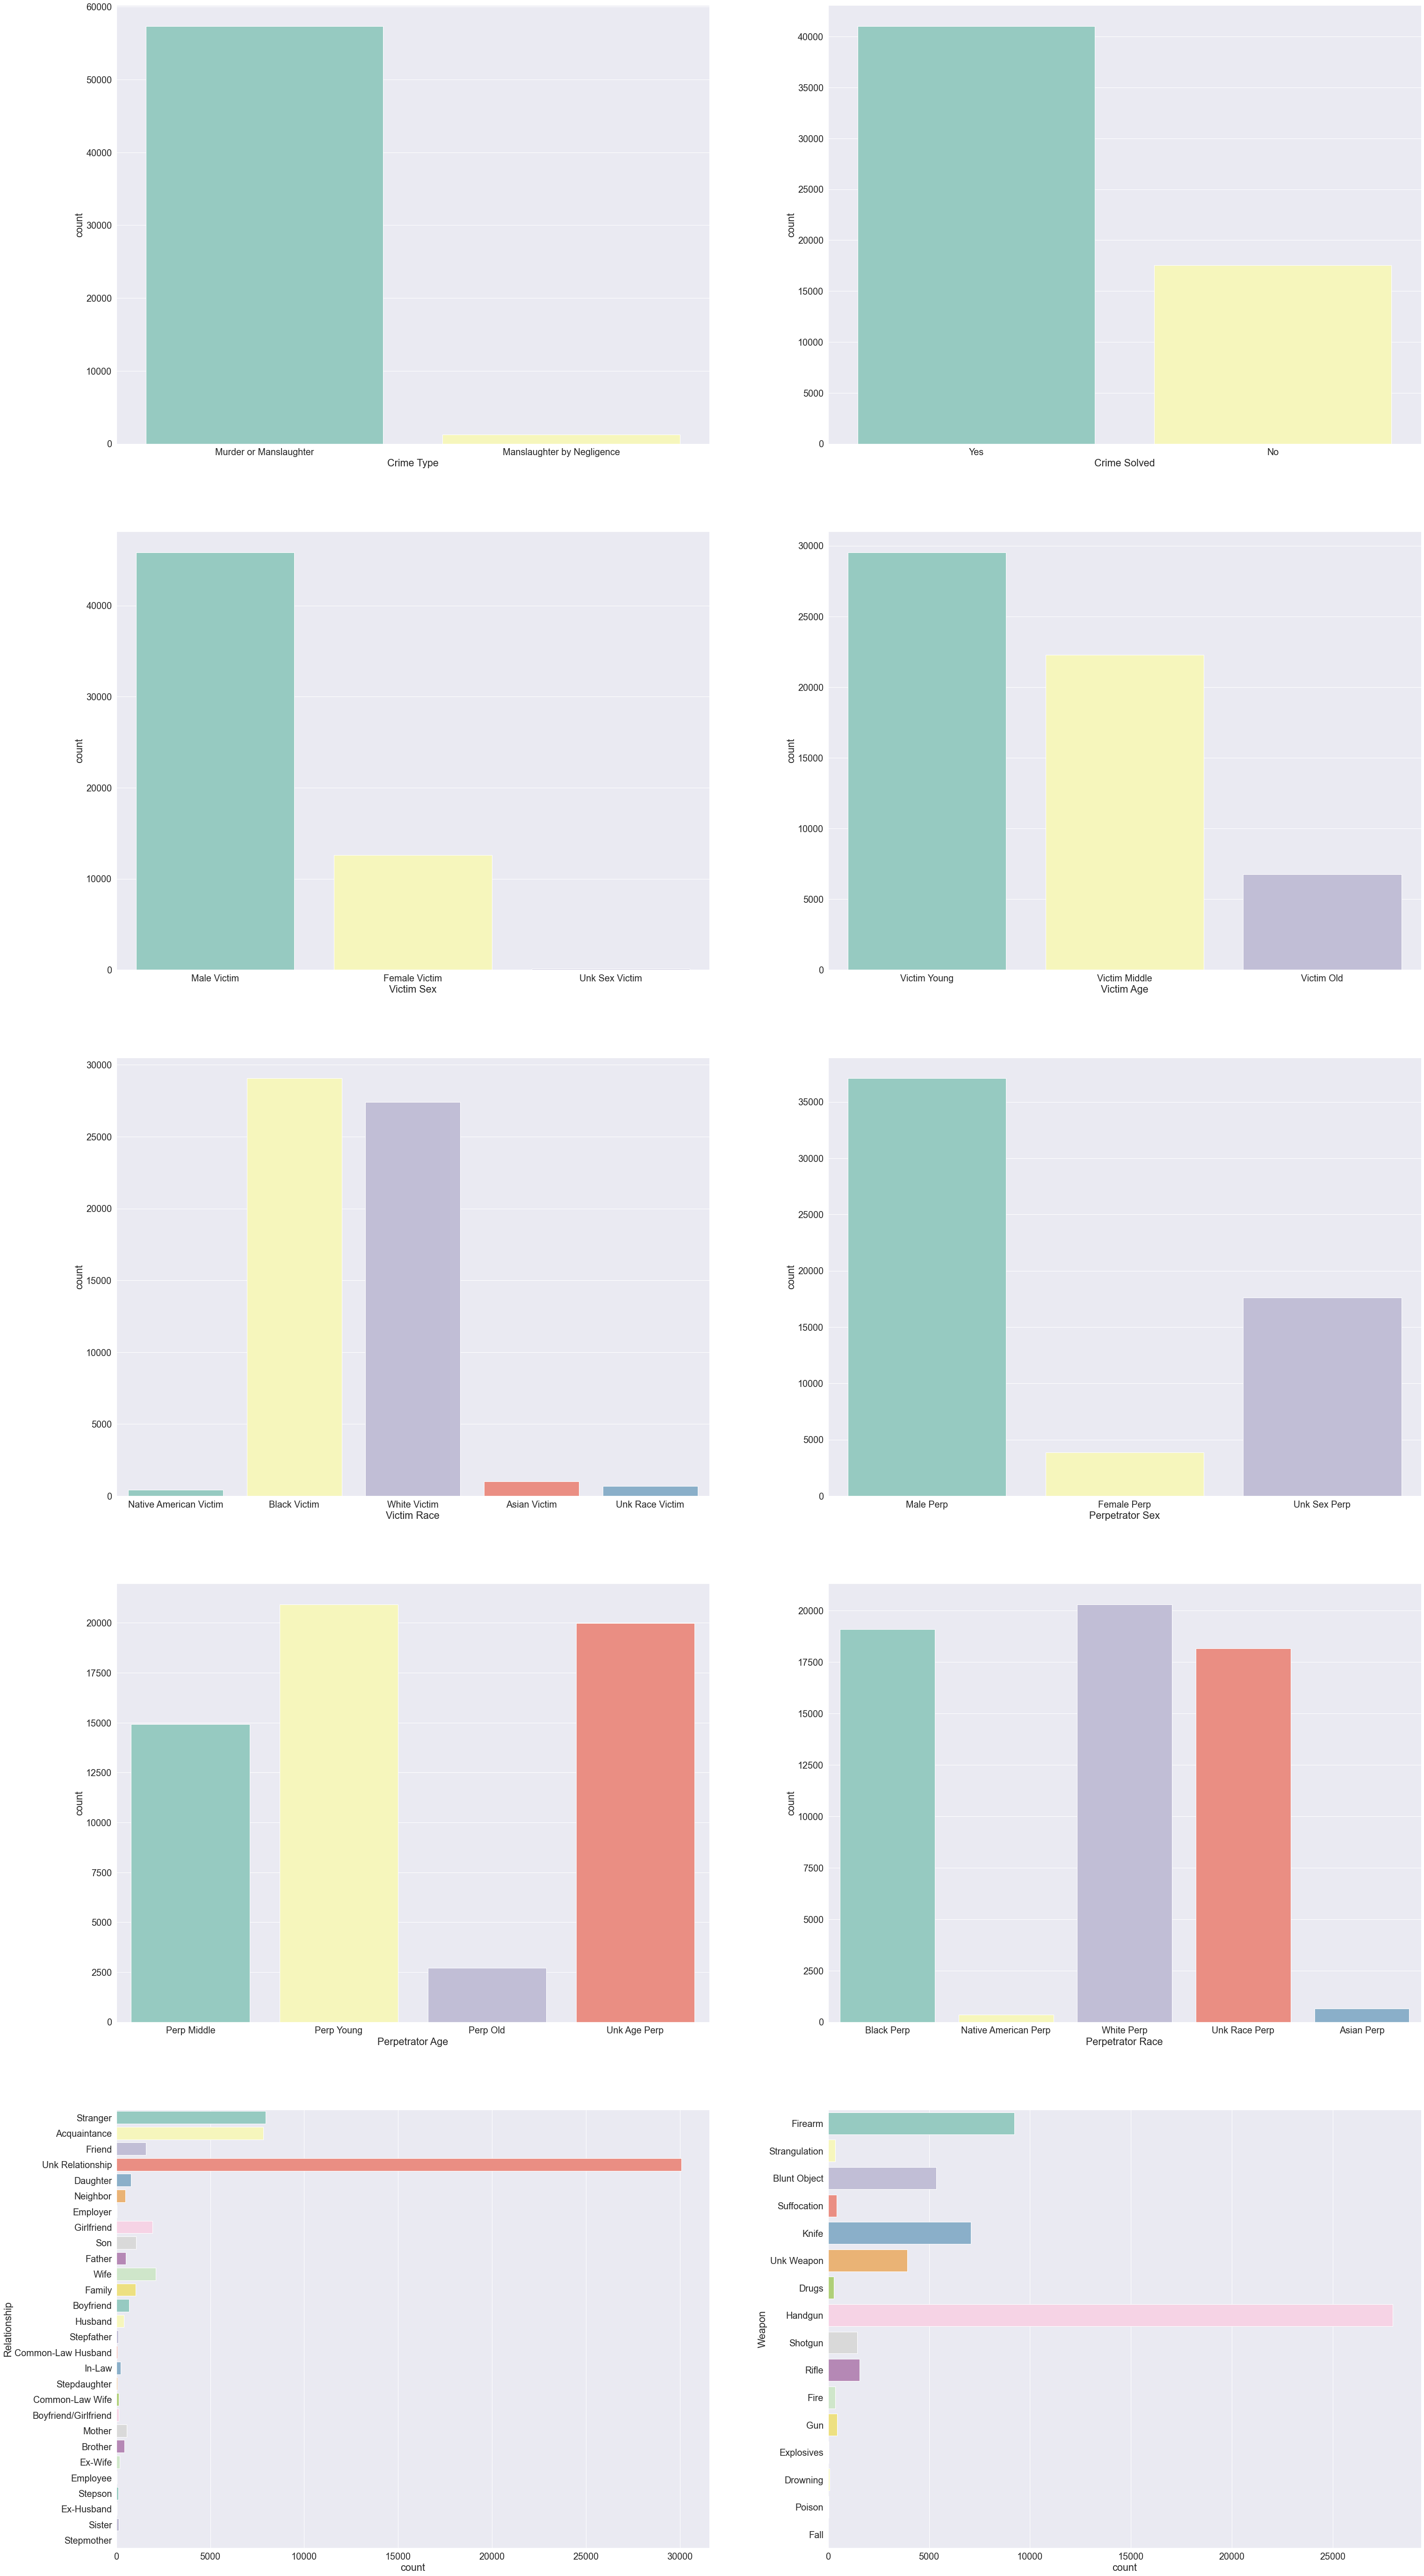

In [29]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 2, figsize = (50, 100))
a = sns.countplot(x=data["Crime Type"], ax  = ax1[0], palette="Set3", edgecolor ="white")
b = sns.countplot(x=data["Crime Solved"], ax  = ax1[1], palette="Set3", edgecolor ="white")
c = sns.countplot(x=data["Victim Sex"], ax  = ax2[0], palette="Set3", edgecolor ="white")
d = sns.countplot(x=data["Victim Age"], ax  = ax2[1], palette="Set3", edgecolor ="white")
e = sns.countplot(x=data["Victim Race"], ax  = ax3[0], palette="Set3", edgecolor ="white")
f = sns.countplot(x=data["Perpetrator Sex"], ax  = ax3[1], palette="Set3", edgecolor ="white")
g = sns.countplot(x=data["Perpetrator Age"], ax  = ax4[0], palette="Set3", edgecolor ="white")
h = sns.countplot(x=data["Perpetrator Race"], ax  = ax4[1], palette="Set3", edgecolor ="white", order = list(set(data["Perpetrator Race"])))
i = sns.countplot(y=data["Relationship"], ax = ax5[0], palette="Set3", edgecolor ="white")
j = sns.countplot(y=data["Weapon"], ax = ax5[1], palette="Set3", edgecolor ="white")
sns.set(font_scale=1.5)
plt.show()

The graphs presented above give some general overview of the data set. Firstly, it is visible that almost all of the crimes were murders or manslaughters. Despite the fact, that most of the crimes were solved still 30% reamined unsolved. It is also possible to observe that usually victims are young an they are males. Moreover, the race of the most victims is either black or white which is not surprising while we take into account US demographic characteristics. 

Regarding perpetrators it might be noticed that in most cases they are young or middle aged and usually they are males. In terms of the race, it is visible that most crimes where commited by white or black perpetrators. However, there are also many cases when perpetrator was unknown.

The last two plots are presenting, respectively, the counts of relationships between the victim and perpetrator and counts of the weapon used. Based on them it was possible to conclude that in many cases the realtionship was unknown and the most popular weapon was the handgun.


## Apriori algorithm

The data set is ready to use so now to find strong patterns between murder cases the apriori algorithm was used. The following analysis is based on the comparison of the three measures that were presented above, support, confidence and lift. At the end they were merged into one table which allowed to come up with some conclusions. During analysis it was necessary to take a closer look at each rule because in some cases the association between two variables might be naturally implied.

In [11]:
basket = []

for i in range(0, len(data.index)): 
  basket.append([str(data.values[i,j]) for j in range(0, len(data.columns))])

In [12]:
rule = apriori(transactions = basket, min_support = 0.003, min_confidence = 0.2, min_lift = 2, max_length = 2, use_colnames=True)
output = list(rule)

In [13]:
def inspect(output):
    lhs = []
    rhs = []
    support = []
    confidence = []
    lift = []
    for item in output:
        pair = item[0]
        items = [x for x in pair]
        lhs.append(items[0])
        rhs.append(items[1])
        support.append(item[1])
        confidence.append(item[2][0][2])
        lift.append(item[2][0][3])
    return list(zip(lhs, rhs, support, confidence, lift))
output_DataFrame = pd.DataFrame(inspect(output), columns = ['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])

In [14]:
output_DataFrame.nlargest(n = 30, columns = 'Lift')

,Left_Hand_Side,Right_Hand_Side,Support,Confidence,Lift
28,Native American Victim,Native American Perp,0.003278,0.534819,74.221970
0,Asian Victim,Asian Perp,0.006830,0.618238,35.848624
4,Female Perp,Boyfriend,0.011099,0.973054,14.691132
13,Female Perp,Husband,0.006693,0.970297,14.649509
7,Daughter,Female Perp,0.005976,0.453368,6.844932
36,Wife,Perp Old,0.010962,0.236464,6.616588
15,Female Perp,Son,0.006796,0.379048,5.722847
26,Mother,Victim Old,0.005771,0.609009,5.270668
11,Father,Victim Old,0.005123,0.595238,5.151488
16,Female Victim,Girlfriend,0.032186,0.977190,4.538394


The table above presents 30 rules with the highest lift score. In this part most of them were verified whether they provide valuable information. Starting from the top, it is possible to observe that in over 50% of cases when the perpetrator was a Native American he also killed a Native American. The lift score was equal to 74 which suggest a very strong association. Similarly, it is for Asian. In 60% of cases when the perpetrator was an Asian he killed also Asian and the lift score also implied strong relationship. 

However,there are some rules which are implied naturally. An example could be that when the victim was a perpetrator's boyfriend then he was killed by a woman. Thus, the analysis should be done carefully. Below some interesting and strong associations are presented:
- Boyfriend -> Knife: There is a rule stating that boyfriends are killed with a knife,
- Blunt Object -> Son: There is a rule stating that when blunt object was used as a weapon then the son was killed by it,
- Blunt Object -> Daughter: There is a rule stating that when blunt object was used as a weapon then the daughter was killed by it,
- Female Victim -> Strangulation: There is a rule stating that females are killed by strangulation,
- Drugs -> White Perp: There is a rule stating that when victim is killed by drugs than the perpetrator was white.

### Visualizations

To obtain better insights regarding results, the heatmap was created. In short each of the rectangles indicates which items are associated to each other. The number located inside of it represents the lift value of the rule. Here, we can notice that associations between North American Victim and North American Perpetrator are very strong. Similarly, between Asian Perpetrator and Asian Victim. The rest of the rules still got very high lift value, around 4.5.

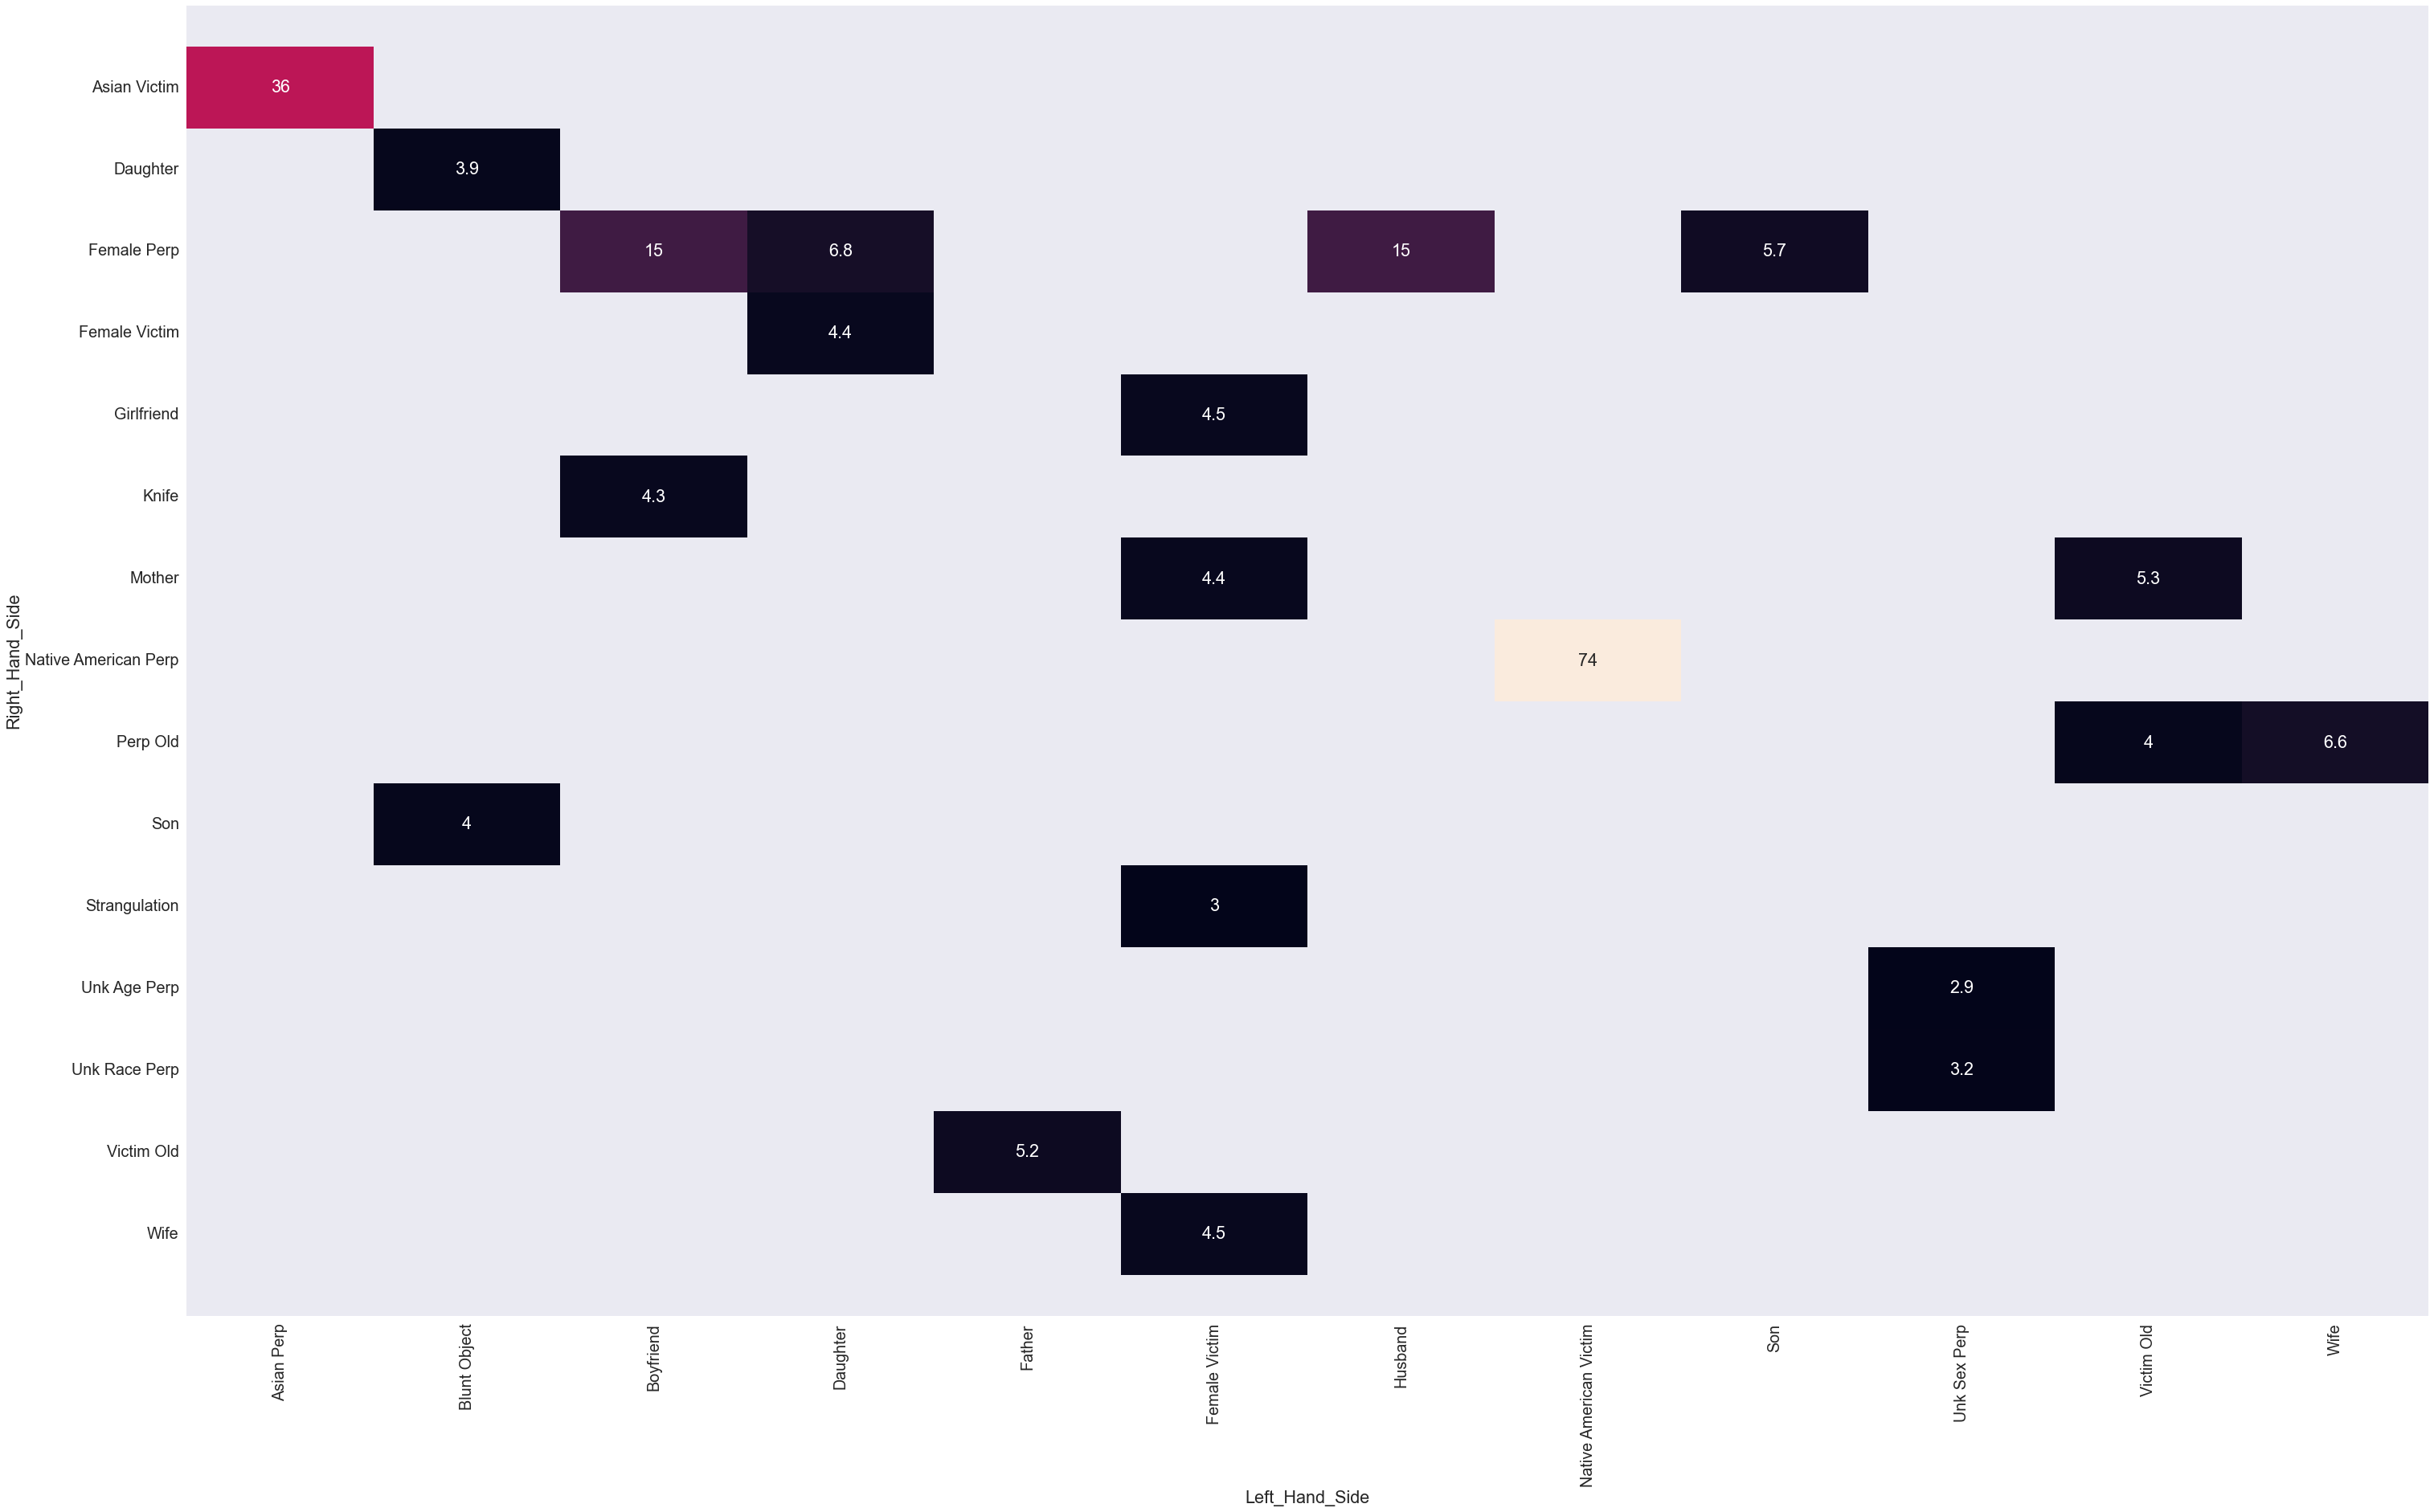

In [464]:
coords = output_DataFrame.nlargest(n = 20, columns = 'Lift')[['Left_Hand_Side','Right_Hand_Side', 'Lift']]
coords.reset_index(inplace = True)
coords = coord.drop(["index"], axis = 1)
coords.reset_index(inplace = True)
pivot = coords.pivot(index = 'Right_Hand_Side', 
                    columns = 'Left_Hand_Side', values= 'Lift')

plt.figure(figsize=(50,30))
sns.heatmap(pivot, annot = True, cbar = False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

The second plot is the scatter plot presenting the confidnce and support values for almost all rules. Based on the plot we can notice that most of the items sets are characterized with really low support. However, in terms of the confidence values we can notice that the distribution of the rules is relatively equal. 

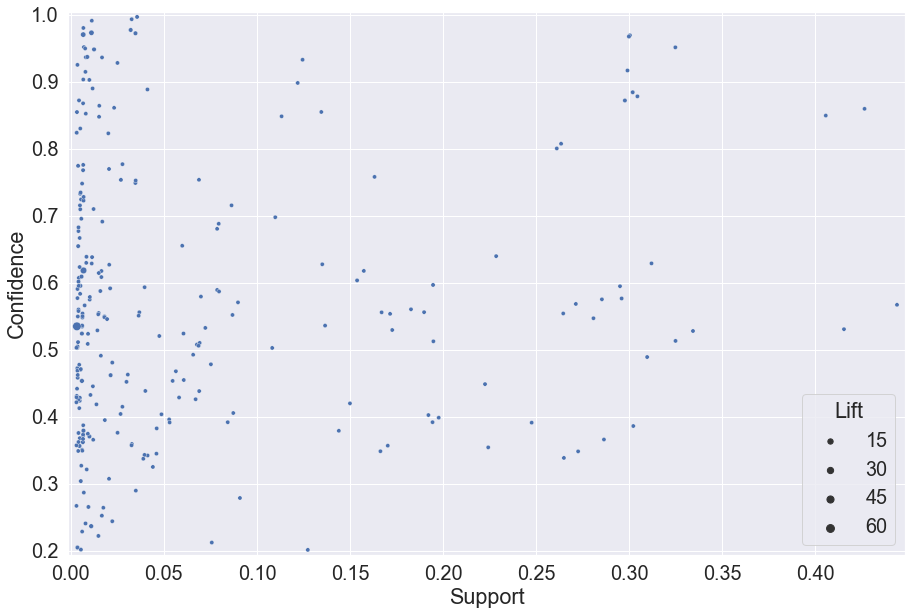

In [466]:
rule2 = apriori(transactions = basket, min_support = 0.003, min_confidence = 0.2, min_lift=1.01, max_length = 2, use_colnames=True)
output2 = list(rule2)
output_DataFrame2 = pd.DataFrame(inspect(output2), columns = ['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])
# Generate scatterplot using support and confidence
plt.figure(figsize=(15,10))
sns.scatterplot(x = "Support", y = "Confidence", size="Lift", data = output_DataFrame2)
plt.margins(0.01,0.01)
plt.show()

The last plot presents the associations between variables. The aim of this plot is just to visualize the connections in simpler way. So that, it would be relatively easy to obtain the most crucial rules that had been established during analysis.

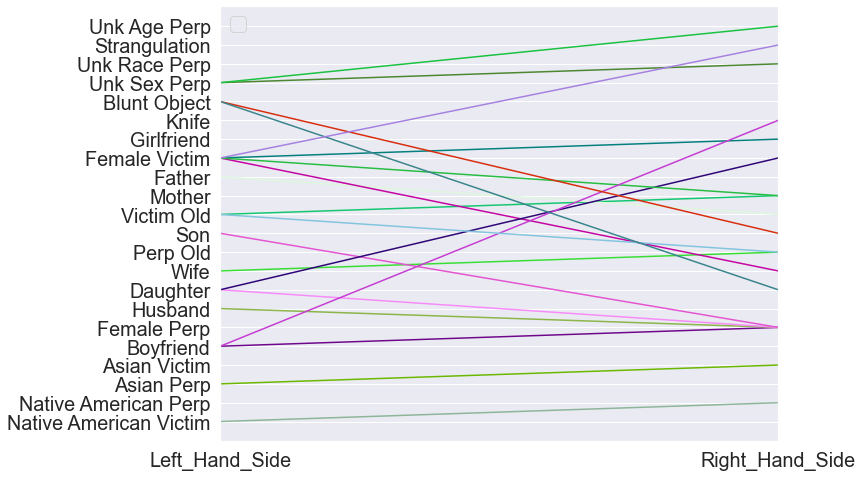

In [479]:
coords = output_DataFrame.nlargest(n = 20, columns = 'Lift')[['Left_Hand_Side','Right_Hand_Side']]
coords.reset_index(inplace = True)
coords = coords.drop(["index"], axis = 1)
coords.reset_index(inplace = True)
plt.figure(figsize=(10,8))
parallel_coordinates(coords,"index")
plt.legend([])
plt.grid(True)
plt.show()

## Conclusion

In general this study provided some insights into finding new patterns between murders. However, it was very difficult to come up with one good answer here. The reason for that was the high number of variables that were examined. So that, the conclusion depended on the researcher. Basically, assuming that the rules  with lift above 2 are considered as a strong ones then we have 42 rules to examine. As it was said in the analysis some of them are implied from each other but still we have a lot of them to check. Thus, for each researcher the rules that are interesting and valuable might differ. Eventually, in this study seven of them were presented. They were characterized with high confidence and lift values. 

In further analysis some of the variables could be grouped more generally, especially weapons, and then the researcher could apply the apriori algorithm with larger frozen sets. 

## References

https://goldinlocks.github.io/Market-Basket-Analysis-in-Python/

https://www.researchgate.net/publication/321338934_Crime_Analysis_Based_on_Association_Rules_Using_Apriori_Algorithm

https://www.geeksforgeeks.org/implementing-apriori-algorithm-in-python/

https://www.section.io/engineering-education/apriori-algorithm-in-python/